# 1. Label Propagation for Node Classification

In [2]:
import random
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [3]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)
seed_everything(42)

## 1.1. Probabilistic Relational Classifier

### 1.1.1. Construct a simplified graph with a edge list and a set of node attributes (with and without label)

In [6]:
class ProbabilisticRelationalClassifier:
    def __init__(
        self,
        max_iter: int = 10,
        threshold: float = 0.01,
        node_size: int = 2500,
        node_font_size: int = 10,
        title_font_size: int = 16,
        fig_size: Optional[Tuple[int, int]] = None,
        seed: int = 42,
    ) -> None:
        # Initialize the classifier with the given parameters
        self.max_iter = max_iter
        self.threshold = threshold
        self.node_size = node_size
        self.node_font_size = node_font_size
        self.title_font_size = title_font_size
        self.fig_size = fig_size
        self.seed = seed

    def _iteration(self) -> None:
        # Perform one iteration of probability updates
        for node in self._G.nodes(data=True):
            if node[1]["label"] is None: # Only update unlabeled nodes
                prob = np.mean([self._G.nodes[neighbor]["prob"] for neighbor in self._G.neighbors(node[0])])
                # If the change in probability is less than the threshold, update the node
                if abs(node[1]["prob"] - prob) < self.threshold:
                    node[1]["label"] = round(prob)
                # Otherwise, update the probability
                node[1]["prob"] = prob

    def _initialization(self):
        # Initialize the probabilities of the nodes
        for node in self._G.nodes(data=True):
            # Set initial probability to 0.5 if the node is unlabeled, 1.0 for labeled as 1, 0 for labeled as 0
            node[1]["prob"] = 0.5 if node[1]["label"] is None else 1.0 if node[1]["label"] else 0.0

    def _is_converged(self) -> bool:
        # Check if all nodes have been labeled
        return not any(label is None for _, label in nx.get_node_attributes(self._G, "label").items())

    def _draw(self) -> None:
        # Visualize the graph
        node_colors = [
            "tab:gray" if node[1]["label"] is None else "tab:blue" if node[1]["label"] else "tab:orange"
            for node in self._G.nodes(data=True)
        ]
        # Create labels with node ID and probability
        node_lables = {node[0]: f"{node[0]}\nP={node[1]['prob']:.2f}" for node in self._G.nodes(data=True)}
        pos = nx.spring_layout(self._G, seed=self.seed)
        # Draw the graph
        nx.draw(
            self._G,
            pos=pos,
            node_color=node_colors,
            labels=node_lables,
            node_size=self.node_size,
            font_size=self.node_font_size,
            with_labels=True,
        )

    def predict(self, G: nx.Graph, display: bool = True) -> nx.Graph:
        # Predict the labels of the graph G
        self._G = G.copy() # Work on a copy of the graph
        num_iter = 0
        self._initialization() # Initialize the probabilities
        if display:
            # Display the initial state
            plt.figure(figsize=self.fig_size)
            self._draw()
            plt.title("Initialization", fontsize=self.title_font_size, loc="left")
            plt.show()

        # Iterate until convergence or maximum iterations reached
        while not self._is_converged() and num_iter < self.max_iter:
            self._iteration()
            num_iter += 1
            if display:
                # Display the state after each iteration
                plt.figure(figsize=self.fig_size)
                self._draw()
                plt.title(f"After iteration {num_iter}", fontsize=self.title_font_size, loc="left")
                plt.show()

        return self._G

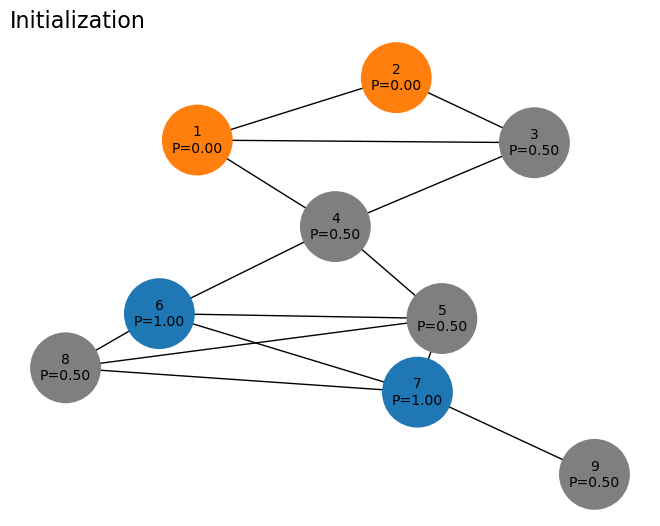

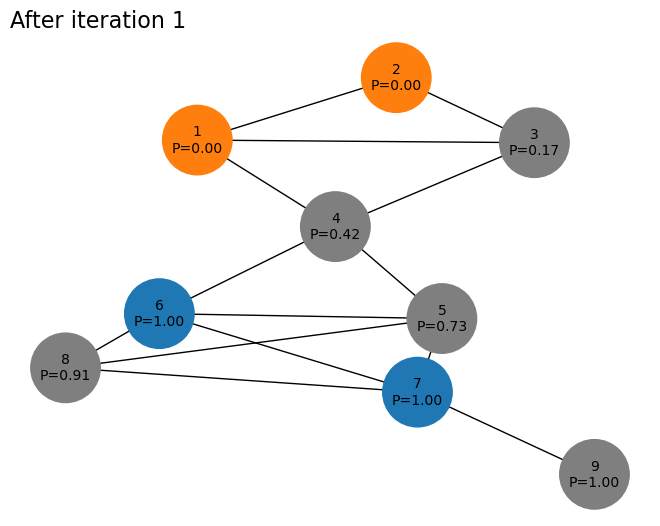

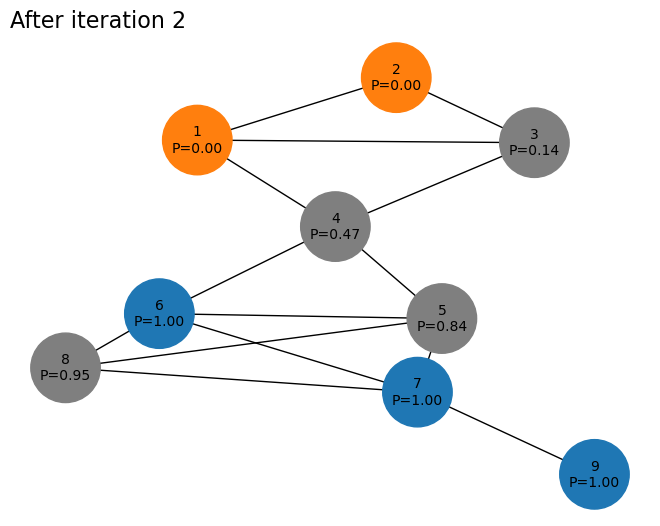

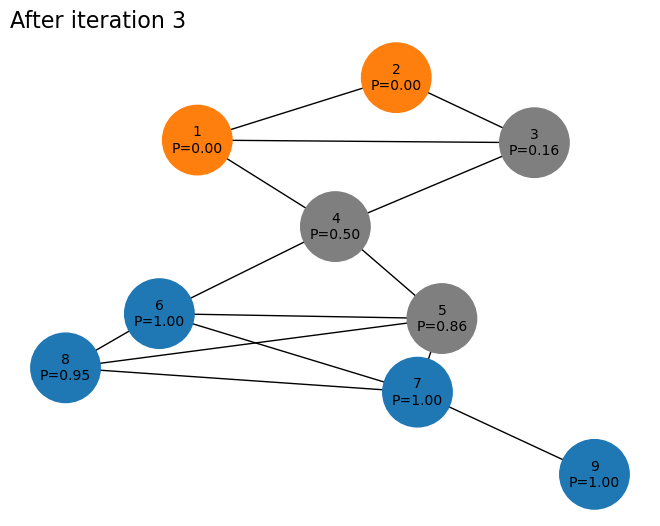

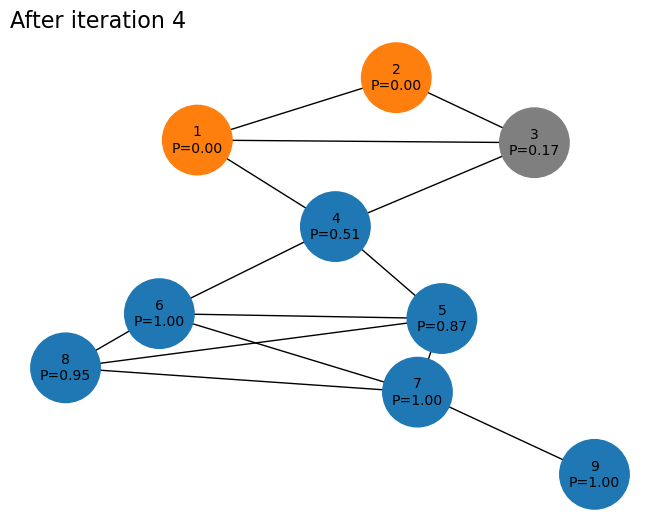

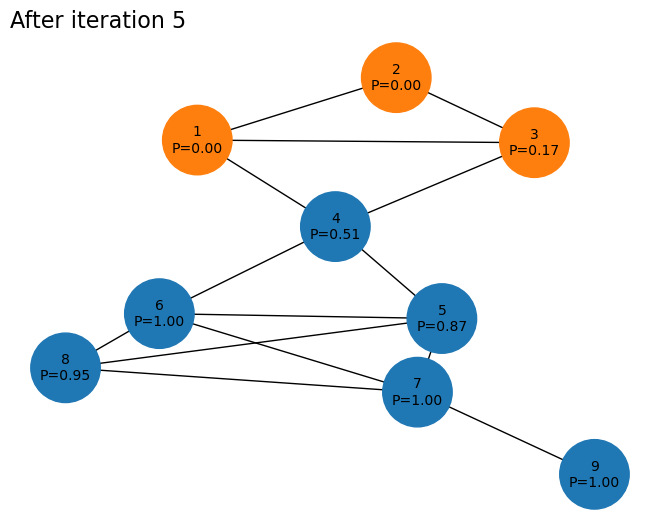

In [10]:
# Edge list of graphs
edge_list = [
    (1, 2), (1, 3), (1, 4),
    (2, 3),
    (3, 4),
    (4, 5), (4, 6),
    (5, 6), (5, 7), (5, 8),
    (6, 7), (6, 8),
    (7, 8), (7, 9),
]
G = nx.Graph(edge_list)

# the node attributes of graphs. There are two types of node attributes: with label and without label
attrs = {
    1: {"label": 0},
    2: {"label": 0},
    3: {"label": None},
    4: {"label": None},
    5: {"label": None},
    6: {"label": 1},
    7: {"label": 1},
    8: {"label": None},
    9: {"label": None},
}
nx.set_node_attributes(G, attrs)

clf = ProbabilisticRelationalClassifier()
_ = clf.predict(G)

# 2. Graph Neural Networks

## 2.1. Installation

In [148]:
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install gif

## 2.2. Import libraries

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import gif

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# Check available styles
print(plt.style.available)

# settings
%matplotlib inline
plt.style.use("ggplot")
gif.options.matplotlib["dpi"] = 300

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## 2.3. Karate Club

In [31]:
# Import the karate club
# Also make sure to check out the other datasets available under `torch_geometric.datasets`
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')

# There can be one or more number of graphs in a dataset
# In this case it is only 1.
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')

# Node labels are the labels of the community that the node ends up joining
# These labels are obtained by via modularity-based clustering
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [32]:
karate_club = dataset[0]  # Get the dataset graph
print(karate_club)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [35]:
# Check if the graph is directed on un-directed
print(f'Karate Club graph is undirected: {karate_club.is_undirected()}')

Karate Club graph is undirected: True


In [37]:
# Get the edge index
edge_index = karate_club.edge_index
# Print the transposed edge index
# The edge index is typically a 2D tensor where each column represents an edge
# Transposing it makes each row represent an edge, which can be easier to read
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [39]:
# Get the feature matrix of the karate club graph
# The feature matrix typically contains the features of each node in the graph
feature_mat = karate_club.x

# Print the feature matrix
print("Feature matrix:")
print(feature_mat)

# Print the feature vector of node 0
# The feature vector of a node is the row of the feature matrix corresponding to that node
print("\nFeature vector for node 0:")
print(feature_mat[0])

Feature matrix:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

Feature vector for node 0:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [41]:
# Get the labels of the nodes in the karate club graph
# The labels typically represent the class or category each node belongs to
labels = karate_club.y

# Print the labels
print(labels)

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


In [43]:
# Train and test split
print("Training mask:")
print(karate_club.train_mask)

Training mask:
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


In [150]:
print(f'Total number of nodes: {karate_club.num_nodes}')
print(f'Number of training nodes: {karate_club.train_mask.sum()}')
print(f'Training node label rate: {int(karate_club.train_mask.sum()) / karate_club.num_nodes:.2f}')

Total number of nodes: 34
Number of training nodes: 4
Training node label rate: 0.12


In [152]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

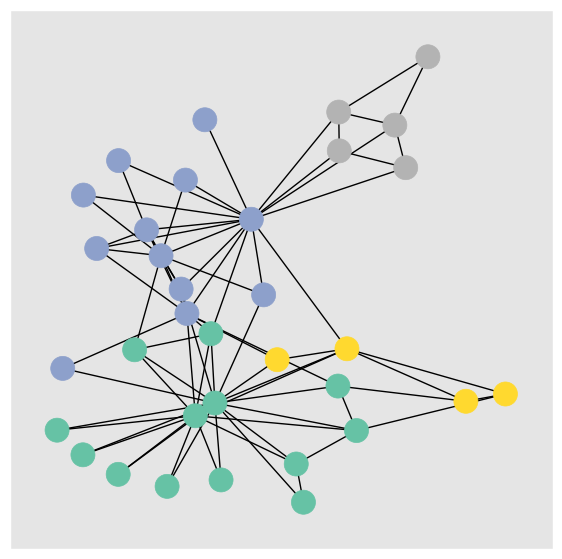

In [154]:
from torch_geometric.utils import to_networkx

# Convert the PyG graph to networkx graph
G = to_networkx(karate_club, to_undirected=True)
visualize_graph(G, color=karate_club.y)

# 3. MLP Model

In [157]:
import torch
from torch.nn import Linear, Dropout, Tanh, ReLU # import the torch layers
torch.manual_seed(140) # for reproducibility

class MLP(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super(MLP, self).__init__()
        # Define the embedding layer that transforms input features to hidden features
        self.embed = Linear(in_channels, hidden_channels)
        # Define the classifier layer that transforms hidden features to output features
        self.classifier = Linear(hidden_channels, out_channels)
        self.activation = ReLU()
        self.dropout = Dropout(0.5)

    def forward(self, graph):
            # Extract the feature matrix from the graph
            x = graph.x
            # Apply the embedding layer
            x = self.embed(x)
            h = self.activation(x)
            h = self.dropout(h)
            x = self.classifier(h)
            # Return the output and hidden representations
            return x, h

In [159]:
model = MLP(dataset.num_features, 16, dataset.num_classes)
print(model)

MLP(
  (embed): Linear(in_features=34, out_features=16, bias=True)
  (classifier): Linear(in_features=16, out_features=4, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


# 4. Visualization

In [162]:
@gif.frame 
def visualize_embedding(h, color, epoch=None, loss=None, acc=None):
        # Create a new figure with specified size
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    # Apply t-SNE to reduce the dimensionality of the hidden representations to 2D
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    # Create a scatter plot of the 2D embeddings
    plt.scatter(z[:, 0], z[:, 1], s=140, c=color, cmap="Set2")

    if epoch is not None and loss is not None and acc is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Acc: {acc.item():.4f}', fontsize=16)

Embedding shape: [34, 16]


<Figure size 800x800 with 0 Axes>

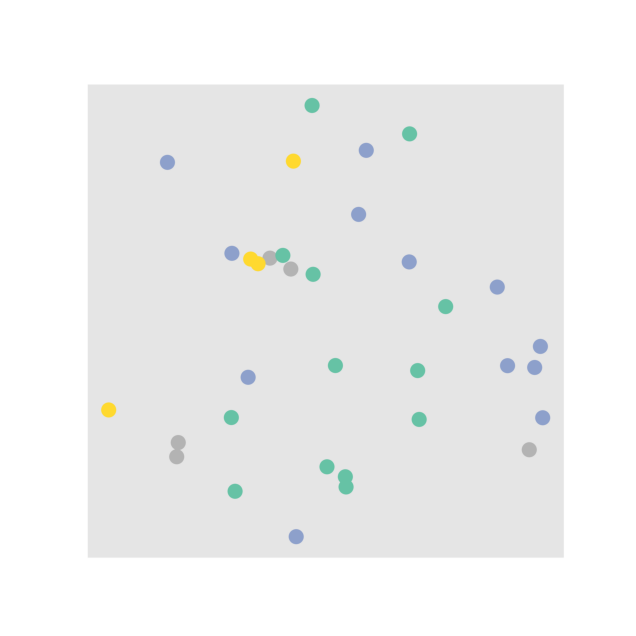

In [164]:
out, h = model(karate_club)
print(f'Embedding shape: {list(h.shape)}')

plt.figure(figsize = (8,8))
fig = visualize_embedding(h, color=karate_club.y)
plt.figure(figsize = (8, 8))
plt.imshow(fig)
plt.axis('off')
plt.show()

In [166]:
def accuracy(logits, labels):
    # find the accuracy 
    pred = torch.argmax(logits, dim=1)
    acc = torch.mean((pred == labels).float())
    return acc

In [168]:
init_acc = accuracy(out, karate_club.y).item() * 100
print(f"The initial accuracy {init_acc:0.03} %")

The initial accuracy 35.3 %


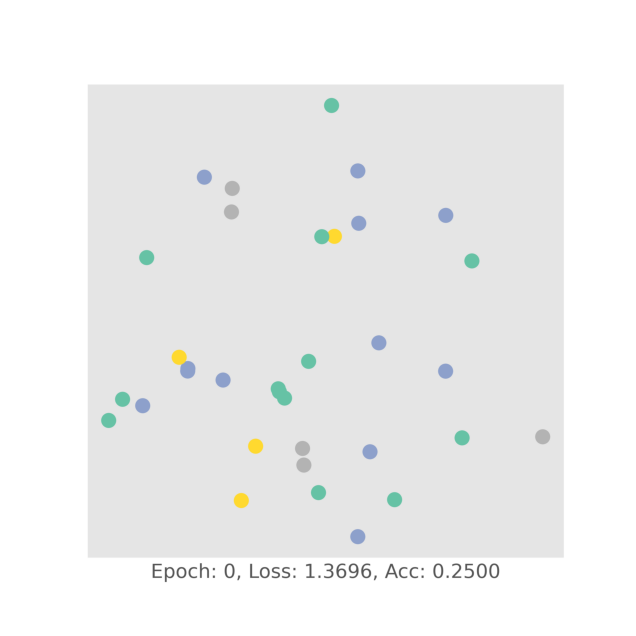

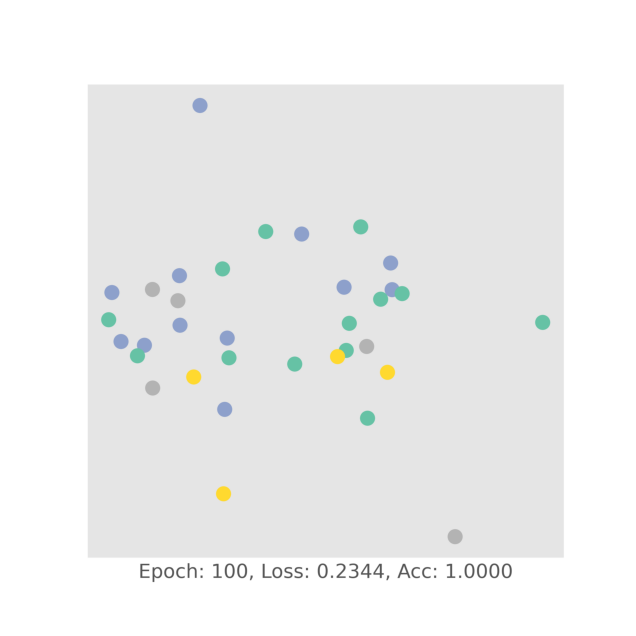

In [179]:
# Restrict height of output cell.
# applicable only for colab
from IPython.display import Javascript

model = MLP(dataset.num_features, 16, 4) # Define  MLP model
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()
    out, h = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    acc = accuracy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h, acc

frames=[]
for epoch in range(200):
    loss, h, acc = train(karate_club)

    if epoch % 100 == 0:
        fig = visualize_embedding(h, color=karate_club.y, epoch=epoch, loss=loss, acc=acc)
        frames.append(fig)
        plt.figure(figsize = (8, 8))
        plt.imshow(fig)
        plt.axis('off')
        plt.show()

In [180]:
train_accuracy = accuracy(model(karate_club)[0][karate_club.train_mask], karate_club.y[karate_club.train_mask])
test_accuracy = accuracy(model(karate_club)[0][~karate_club.train_mask], karate_club.y[~karate_club.train_mask])
total_accuracy = accuracy(model(karate_club)[0], karate_club.y)

print(f"Train accuracy: {train_accuracy * 100:0.03} %")
print(f"Test accuracy: {test_accuracy * 100 : 0.03} %")
print(f"Dataset accuracy: {total_accuracy * 100 : 0.03} %")

Train accuracy: 1e+02 %
Test accuracy:  16.7 %
Dataset accuracy:  44.1 %


# 5.GCN Model

In [142]:
import torch
from torch.nn import Parameter
from torch.nn.functional import relu
import torch.nn.functional as F

class GCNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Define the weight matrix for the GCN layer
        self.weight = Parameter(torch.randn(in_channels, out_channels))
    
    def forward(self, x, edge_index):
        # Initialize node aggregation output
        row, col = edge_index
        # Normalize based on node degree
        deg = torch.bincount(row, minlength=x.size(0)).float()  # Degree of each node
        deg_inv_sqrt = deg.pow(-0.5)  # D^(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0  # Handle division by zero
        
        # Apply normalization to node features
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Aggregate neighbors’ features (message passing)
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col] * norm.view(-1, 1))  # Aggregate neighbor features

        # Apply the learned weight matrix
        out = agg @ self.weight

        return out

# Create an instance of the GCN model
# dataset.num_features: number of input features
# 16: hidden dimension
# dataset.num_classes: number of output classes
model = GCN(dataset.num_features, 16, dataset.num_classes)
print(model)

GCN(
  (embed): GCNConv()
  (activation): ReLU()
  (classifier): Linear(in_features=16, out_features=4, bias=True)
)


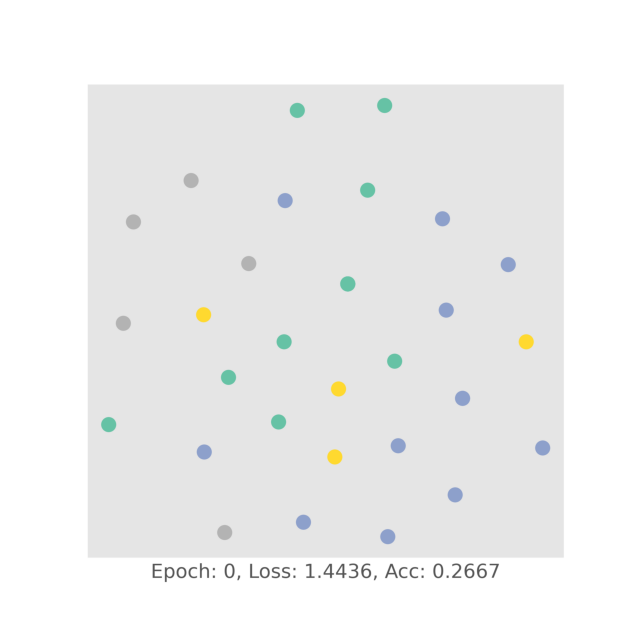

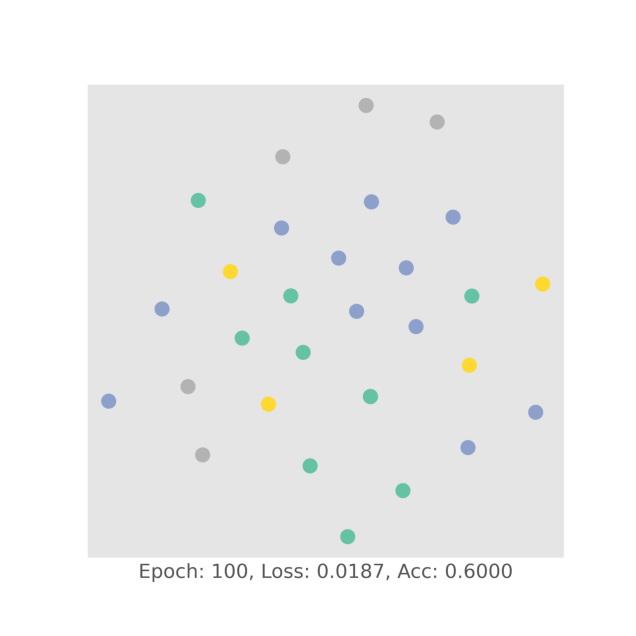

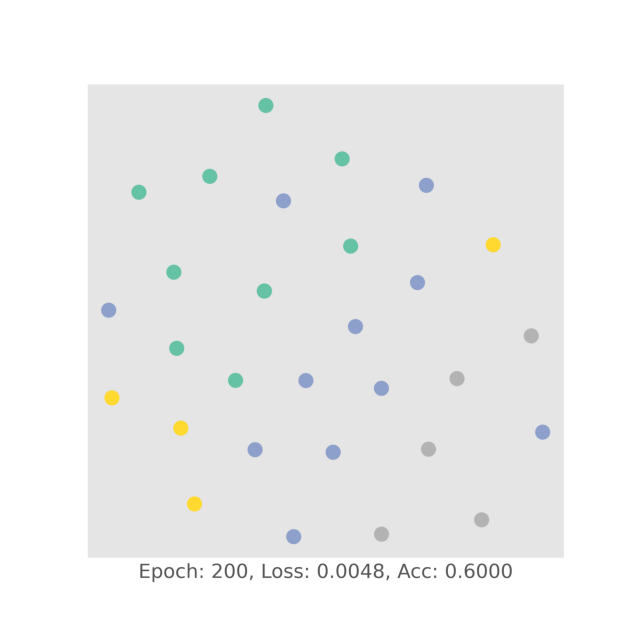

In [144]:
import time
from IPython.display import Javascript  # Restrict height of output cell.


# Initialize the GCN model with input features, hidden layer size, and output classes
model = GCN(dataset.num_features, 16, dataset.num_classes)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    acc = accuracy(out[~data.train_mask], data.y[~data.train_mask])
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, acc

frames=[]
for epoch in range(300):
    loss, h, acc = train(karate_club)

    if epoch % 100 == 0:
        fig = visualize_embedding(h, color=karate_club.y, epoch=epoch, loss=loss, acc=acc)
        frames.append(fig)
        plt.figure(figsize = (8,8))
        plt.axis('off')
        plt.imshow(fig)
        plt.show()
        time.sleep(0.3)

In [145]:
train_accuracy = accuracy(model(karate_club.x, karate_club.edge_index)[0][karate_club.train_mask], karate_club.y[karate_club.train_mask])

test_accuracy = accuracy(model(karate_club.x, karate_club.edge_index)[0][~karate_club.train_mask], karate_club.y[~karate_club.train_mask])

total_accuracy = accuracy(model(karate_club.x, karate_club.edge_index)[0], karate_club.y)

print(f"Train accuracy: {train_accuracy * 100:0.03} %")
print(f"Test accuracy: {test_accuracy * 100 : 0.03} %")
print(f"Dataset accuracy: {total_accuracy * 100 : 0.03} %")

Train accuracy: 1e+02 %
Test accuracy:  60.0 %
Dataset accuracy:  64.7 %
